In [ ]:
import numpy as np
import pandas as pd
import multiprocessing

import matplotlib.pyplot as plt
import bokeh
import bokeh.io
from bokeh.plotting import figure
from bokeh.io import output_notebook, show

# init_notebook_mode()

import seaborn as sns

import re
import math
import copy

from collections import defaultdict
import csv
import itertools
import datetime 
from datetime import datetime
import time
import dateutil.parser
import pickle
import random

import gc
import zipfile
import sys, getopt
import os

from IPython.core.interactiveshell import InteractiveShell
from io import StringIO

import dask.dataframe as dd
#from chest import Chest

InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last"

# Magic function to make matplotlib inline
%matplotlib inline

%config InlineBackend.figure_formats = {'png', 'retina'}

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

import dask.dataframe as ddf
import dask.array as da

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 800)

import scipy

import statsmodels.api as sm

# Functions

In [ ]:
def initialize_parameters(par = np.array([0.5, 0.9, 0, 1, 0])):
    # np.random.seed(3)
    parameters = {}

    parameters['alpha'] = par[0]
    parameters['beta'] = par[1]
    parameters['omega'] = par[2]* (1-par[1])    # one way to choose that is omega/(1-beta) = unconditional mean 
    parameters['sigma'] = par[3]
    parameters['f0'] = par[4]                   # one way to choose is unconditional mean 

    return parameters

def loglik(y, f, x, sigma):
    ll = -1/2*np.log(2*np.pi ) - 1/2*np.log(sigma) - 1/(2*sigma)*(y - x*f)**2 
    return ll


def score_compute(y, f, x, parameters, epsilon = 1e-7 ):
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    
    score = (y - x*f)/sigma
    # score = (y - x*f)
    
    return score

def filterGAS(y, x, parameters):
    
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    score0 = score_compute(y[0,:],  f0, x[0,:], parameters, epsilon = 1e-7) 
    f = np.zeros((len(y),1))
    
    f[0,:] = f0
    for t in range(1,len(y)):
        scoret = score_compute(y[t-1,:], f[t-1,:], x[t-1,:], parameters, epsilon = 1e-7) 
        f[t,:] = omega + alpha*scoret + beta*f[t-1,:] 

    return f

def loglikest(par, y, x):
    parameters = initialize_parameters(par)
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    sigma = parameters["sigma"]
    # f0 = parameters["f0"]
    
    f = filterGAS(y, x, parameters) 
    ll = np.zeros((len(y), 1))
    m = len(y)

    for t in range(0, len(y)):
         ll[t,:] = loglik(y[t,:], f[t,:], x[t,:], sigma)
    loglik_res = -(np.sum(ll))/m
        
#     else:
#         loglik_res=10**9 # causing gradient problems??

    return loglik_res

In [ ]:
def score_compute_2(y, f, x, parameters, epsilon = 1e-7 ):
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    
    score = (y - x*f) # ** The 'type = 2' modification **
    
    return score

def filterGAS_2(y, x, parameters):
    
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    score0 = score_compute_2(y[0,:],  f0, x[0,:], parameters, epsilon = 1e-7) 
    f = np.zeros((len(y),1))
    
    f[0,:] = f0
    for t in range(1,len(y)):
        scoret = score_compute_2(y[t-1,:], f[t-1,:], x[t-1,:], parameters, epsilon = 1e-7) 
        f[t,:] = omega + alpha*scoret + beta*f[t-1,:] 

    return f

def loglikest_2(par, y, x):
    parameters = initialize_parameters(par)
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    sigma = parameters["sigma"]
    # f0 = parameters["f0"]
    
    f = filterGAS_2(y, x, parameters) 
    ll = np.zeros((len(y), 1))
    m = len(y)

    for t in range(0, len(y)):
         ll[t,:] = loglik(y[t,:], f[t,:], x[t,:], sigma)
    loglik_res = -(np.sum(ll))/m
        
#     else:
#         loglik_res=10**9 # causing gradient problems??

    return loglik_res

In [ ]:
def GAS_est(df):
    
    y = df.net_qty.values          # observed demand (response)
    x = df.buy_availability.values # buy_availability (explanatory)

    y = y.reshape((len(y),1)) 
    x = x.reshape((len(y),1))
    
    ret = pd.DataFrame()
    ret['year'] = df['year']
    ret['week'] = df['week']
        
    abc = scipy.optimize.minimize(
        loglikest,                                       # function to minimize (log likelihood y|x,theta)
        np.array([0.8, 0.9, np.mean(y), 1, np.mean(y)]), # initial parameter values (starting)
        args=(y, x), 
        options ={'eps':1e-09, 'maxiter': 600, 'ftol': 1e-12},
        method='L-BFGS-B', 
        bounds=((0,  None),             # alpha
                (-1, 1),                # beta
                (0.001, np.mean(y)*2),  # omega 
                (0.001, None),          # sigma
                (0.001, np.mean(y)*2)   # f
               )
    )
    
    
    # --- CONVERGENCE control flow ---
    if abc.success == True:
        
        x1par = initialize_parameters(abc.x) 
        f_est = filterGAS(y, x, x1par)
        
        ret['f_est'] = f_est 
        ret['Convergence'] = [abc.success] * len(y)
        ret['Convg type'] = ['One'] * len(y)
        
    # **Modification if first algorithm fails
    elif abc.success == False:
        
        abc = scipy.optimize.minimize(
            loglikest_2,                                       # function to minimize (log likelihood y|x,theta)
            np.array([0.8, 0.9, np.mean(y), 1, np.mean(y)]),   # initial parameter values (starting)
            args=(y, x), 
            options ={'eps':1e-09, 'maxiter': 600, 'ftol': 1e-12},
            method='L-BFGS-B', 
            bounds=((0,  None),             # alpha
                    (-1, 1),                # beta
                    (0.001, np.mean(y)*2),  # omega 
                    (0.001, None),          # sigma
                    (0.001, np.mean(y)*2)   # f
                   )
                )

        x1par = initialize_parameters(abc.x) 
        f_est = filterGAS_2(y, x, x1par)
        
        ret['f_est'] = f_est 
        ret['Convergence'] = [abc.success] * len(y)
        ret['Convg type'] = ['Two'] * len(y)

    return ret

## Data

In [ ]:
dat0 = pd.read_csv('data/ch4k_df_eu.csv')

ref_dat0 = pd.read_csv('data/dat_ref.csv', low_memory = False, index_col = 0,
                     usecols = ['group_article', 'price_band', 'age_group_descr', 
                                'brand_descr', 'sub_brand_descr',
                                'rmh_retail_department_descr', 'rmh_category_descr', 'rmh_gender_descr',
                                'rmh_retail_section_descr', 'rmh_product_division_descr',
                                'rmh_product_type_descr', 'product_franchise_descr'])

In [ ]:
dat = dat0.copy()

dat.dropna(inplace = True)
dat = dat[(dat.season_net_qty > 250) &
          (dat.country == 'EU')]

# For categorizing on product_type
ref_dat = ref_dat0.copy()
ref_dat = ref_dat.reset_index().drop_duplicates()[['group_article', 'rmh_product_type_descr']]

dat = pd.merge(dat, ref_dat, left_on='article_number', right_on='group_article', how = 'left')

# For sorting
key = {'FW16': 1, 'SS17': 2, 'FW17': 3, 'SS18': 4, 'FW18': 5, 'SS19': 6, 'FW19': 7, 'SS20': 8}
dat['order_key'] = [key[s] for s in dat.season]

## Seasonality by product type

In [ ]:
seasonality = pd.DataFrame(dat.groupby(['rmh_product_type_descr', 'week'])['net_qty'].mean())
seasonality.reset_index(inplace = True)

# GAS

In [ ]:
dat_SS19 = dat[(dat.season == 'SS19') & 
          (dat.country == 'EU') & 
          (dat.season_net_qty > 100) &
          (dat.season_net_qty != 0)].copy()

dat_SS19.sort_values(['article_number', 'year', 'week'], inplace = True)

dat_SS19.set_index(['article_number'], inplace = True)

#   --- RANDOM SUBSET OF ARTICLES ---
a = np.random.choice(dat_SS19.index.unique(), size = 20, replace = False)
dat_SS19 = dat_SS19.loc[a ,:].copy()
#   ---- ---- ---- ---- ---- ---- 

dat_SS19.reset_index(inplace = True)


In [ ]:
%%time 

dat_GAS = dat_SS19.groupby('article_number').apply(GAS_est)
dat_GAS.reset_index(inplace = True)



## Combine

In [ ]:
dat_GAS.head()
dat_GAS.shape

dat_SS19.head()
dat_SS19.shape

In [ ]:
dat_SS19 = dat_SS19.merge(
    dat_GAS[['article_number', 'year', 'week', 'f_est']], 
    how = 'left', 
    on = ['article_number', 'year', 'week']).sort_values(['article_number', 'year', 'week'])

dat_SS19 = dat_SS19[['article_number', 'year', 'week', 'net_qty', 'rmh_product_type_descr', 'f_est']]

seasonality.rename(columns = {'net_qty': 'type_week_avg'}, inplace = True)

dat_SS19 = pd.DataFrame(pd.merge(dat_SS19, seasonality, how = 'left'))

In [ ]:
dat_SS19.dropna(inplace = True)

## Seasonality Prediction Column

In [ ]:
def ols_preds(df):
    ret = pd.DataFrame()
    ret['week'] = df['week']
        
    mod = sm.OLS(df.net_qty, df.type_week_avg, missing = 'drop')
    mod_fit = mod.fit()
    mod_predict = mod_fit.predict()
    
    ret['preds'] = mod_predict
    
    return ret  

In [ ]:
preds = dat_SS19.groupby(['article_number']).apply(ols_preds)
preds.reset_index(inplace = True)

In [228]:
dat_SS19 = pd.merge(dat_SS19, preds)

# Add buy_availability for plotting
dat_SS19 = dat_SS19.merge(dat[['article_number', 'year', 'week', 'buy_availability']],
               how = 'left')

In [226]:
dat_SS19
dat_SS19.shape
len(dat_SS19.article_number.unique())

,article_number,year,week,net_qty,rmh_product_type_descr,f_est,type_week_avg,level_1,preds
0,BB7341,2018.0,49.0,28,SHOES (LOW),31.936267,26.021251,0,25.917742
1,BB7341,2018.0,50.0,12,SHOES (LOW),29.559412,36.382594,1,36.237869
2,BB7341,2018.0,51.0,12,SHOES (LOW),-9.448935,33.039117,2,32.907692
3,BB7341,2018.0,52.0,103,SHOES (LOW),72.246024,35.646535,3,35.504738
4,BB7341,2019.0,1.0,160,SHOES (LOW),153.310287,37.758089,4,37.607893
5,BB7341,2019.0,2.0,80,SHOES (LOW),197.258418,41.148947,5,40.985262
6,BB7341,2019.0,3.0,22,SHOES (LOW),157.078342,36.063260,6,35.919806
7,BB7341,2019.0,4.0,14,SHOES (LOW),14.396427,29.068154,7,28.952524
8,BB7341,2019.0,5.0,3,SHOES (LOW),51.947512,28.086420,8,27.974696
9,BB7341,2019.0,6.0,4,SHOES (LOW),3.179936,25.844824,9,25.742016


(360, 9)

17

## Plots

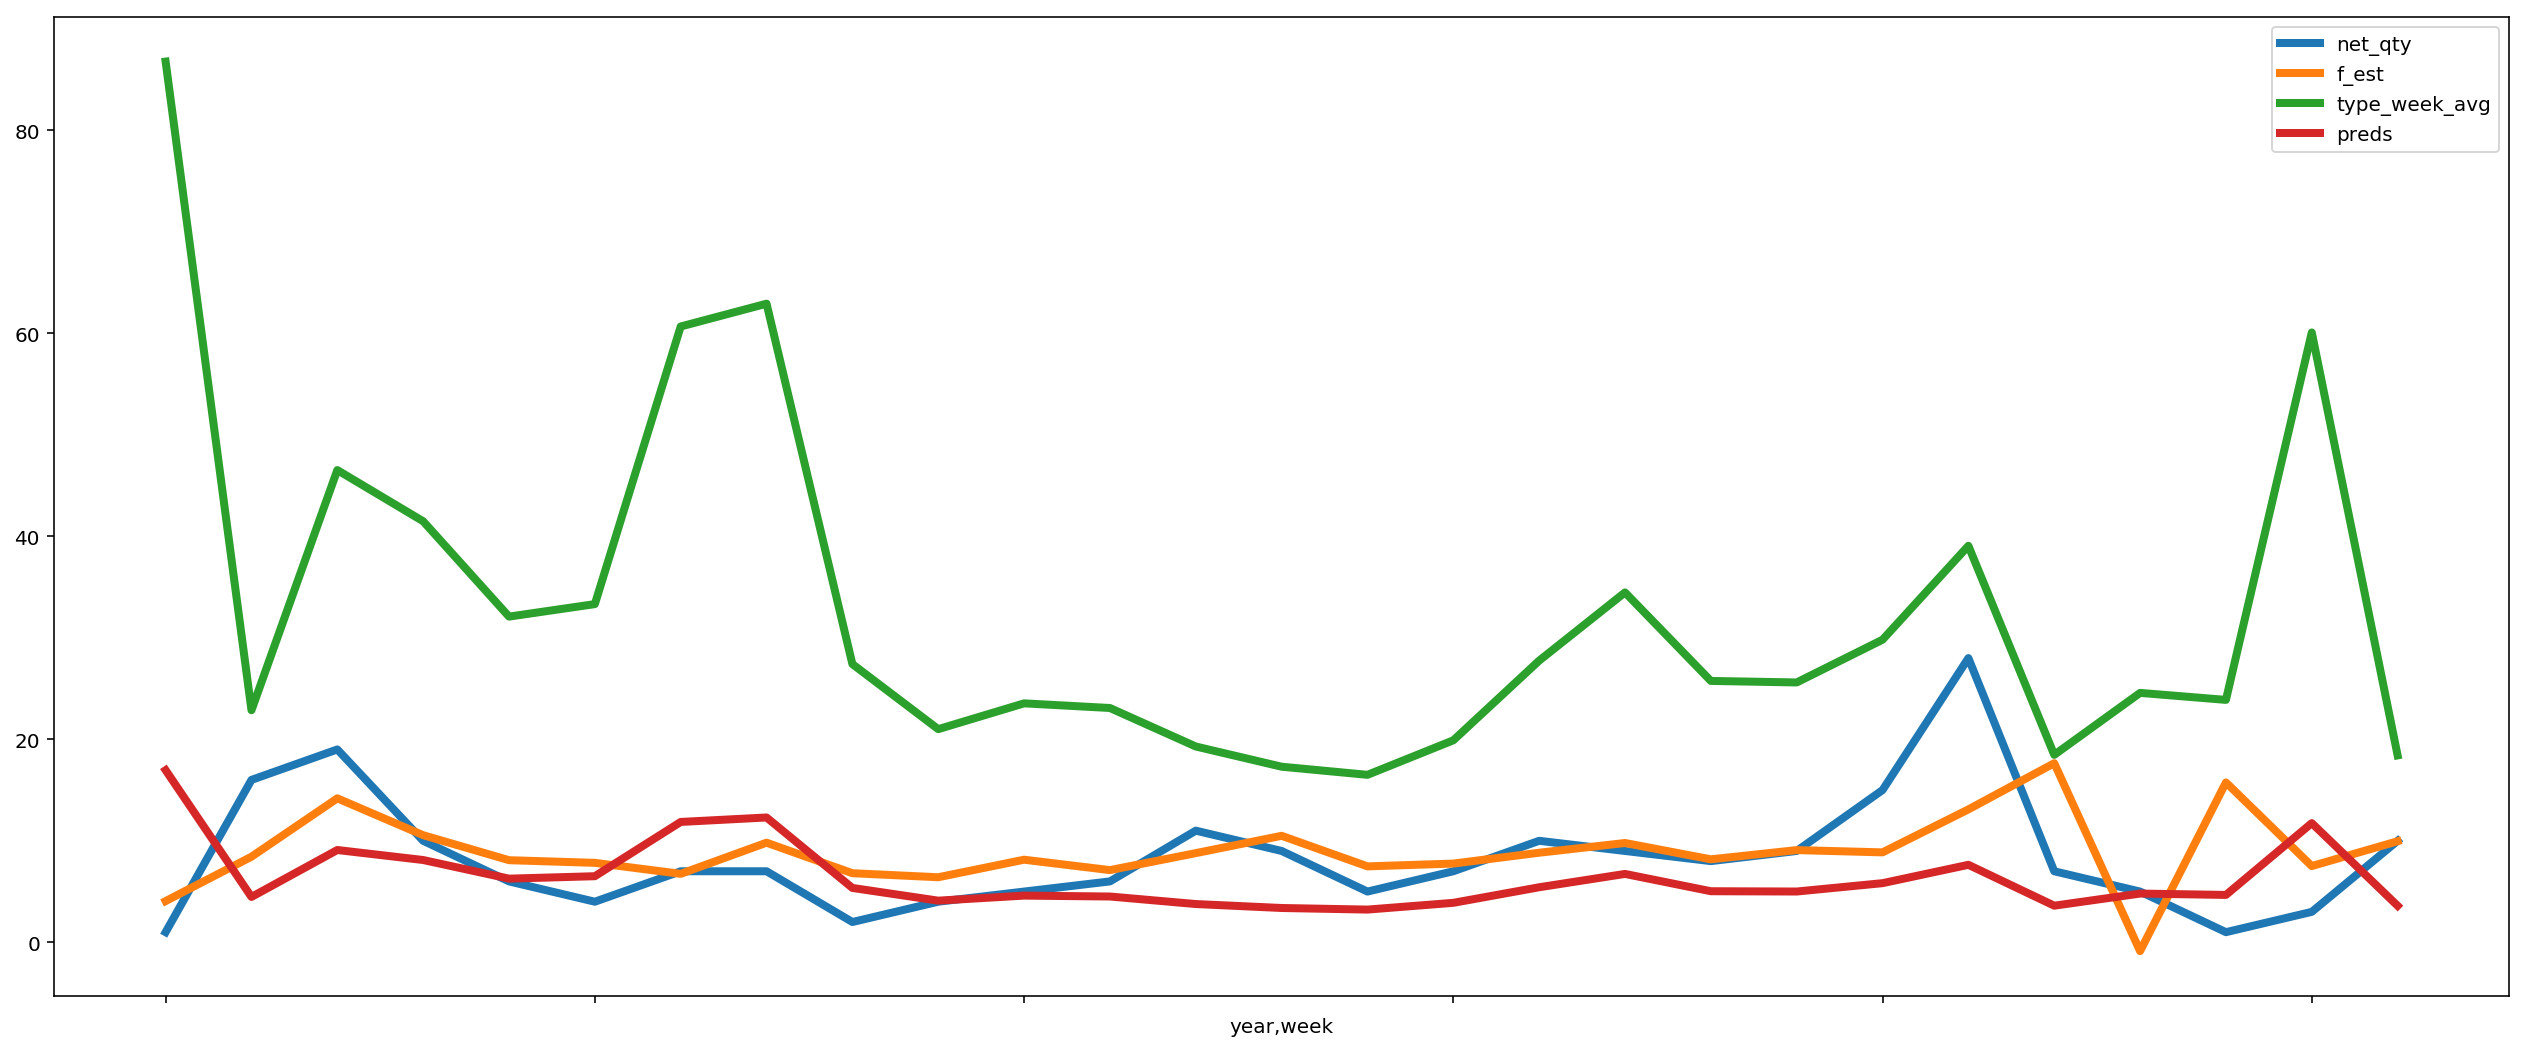

In [251]:
#   --- RANDOM SUBSET OF ARTICLES ---
a = np.random.choice(dat_SS19.article_number.unique(), size = 1, replace = False)[0]
dat_a = dat_SS19[dat_SS19.article_number == a]
#   ---- ---- ---- ---- ---- ---- 
dat_a.set_index(['year', 'week'], inplace = True)

plt.rcParams["figure.figsize"] = [22,9]
dat_a[['net_qty', 'f_est', 'type_week_avg', 'preds']].plot(linewidth = 4)


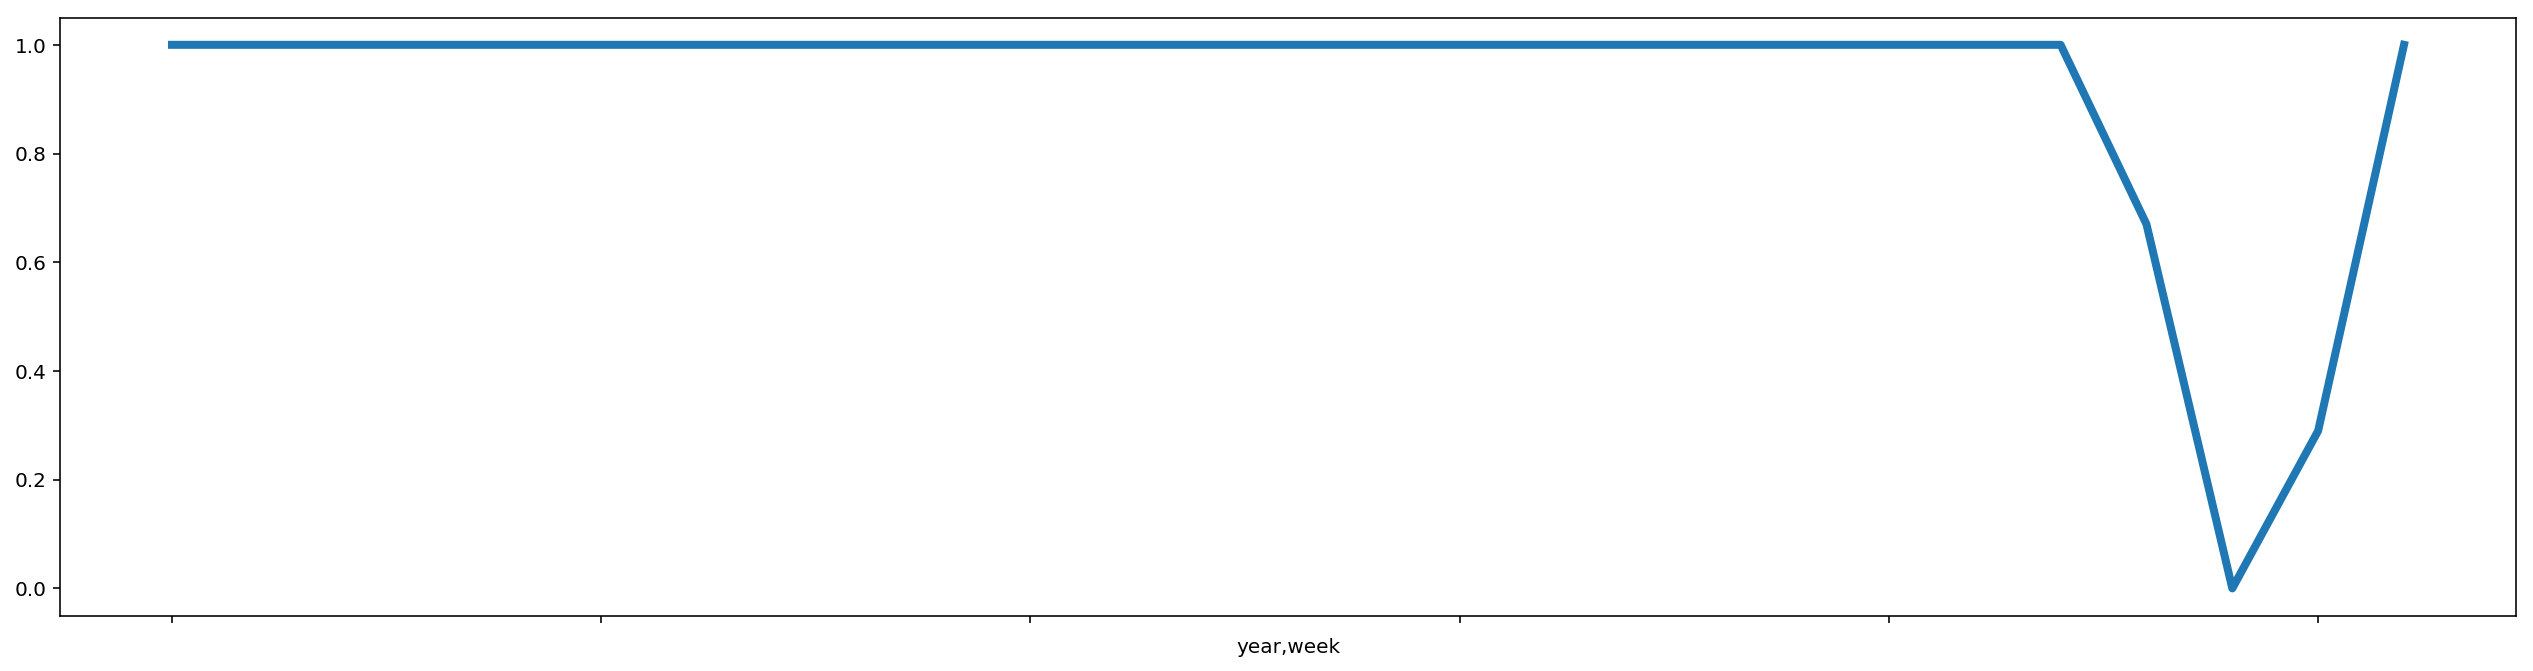

In [252]:
plt.rcParams["figure.figsize"] = [22,5.5]
dat_a['buy_availability'].plot(linewidth = 4)

In [ ]:
# pivoted = dat_SS19.pivot_table(values = 'type_week_avg',
#                               index = ['year', 'week'],
#                               columns = 'article_number')

# plt.rcParams["figure.figsize"] = [22,9]
# pivoted.plot(linewidth = 4)


# Appendix

In [ ]:

# # ---- Add cost ----
# cost_price = pd.read_csv('Cost Price.csv', low_memory=False, index_col = 0)
# cost_price.rename(columns = {'avg(cost_of_sales)': 'cost'}, inplace = True)
# cost_price = pd.DataFrame(cost_price['cost'].groupby(cost_price.index).mean()).round()


In [ ]:
# dat.drop(['plant', 'warehouse'], axis = 1, inplace=True)

# dat.buy_availability = dat.buy_availability.round(2)

# dat.drop_duplicates(['article_number', 'consumer_order_date'], inplace = True)

# dat[dat.duplicated()]

In [ ]:
# len(set(dat2[dat2.season == 'FW18'].article_number).intersection(set(dat2[dat2.season == 'FW19'].article_number)))


In [ ]:
# ref_dat.head()

# pd.crosstab(index = ref_dat['rmh_product_type_descr'], columns = 'count')

# for c in ref_dat.columns:
#     d = ref_dat[c].unique()
#     print('***', c, '***', d)

In [ ]:
# ref_dat = pd.read_csv('data/dat_ref.csv', low_memory = False, index_col = 0,
#                      usecols = ['group_article', 'price_band', 'age_group_descr', 
#                                 'brand_descr', 'sub_brand_descr',
#                                 'rmh_retail_department_descr', 'rmh_category_descr', 'rmh_gender_descr',
#                                 'rmh_retail_section_descr', 'rmh_product_division_descr',
#                                 'rmh_product_type_descr', 'product_franchise_descr'])

# ref_dat2 = pd.read_csv('data/Article reference data.csv', low_memory = False, index_col = 0, error_bad_lines = False,
#                       usecols = ['model_no', 'key_cat_desc', 'sports_cat_desc', 'rmh_cat_desc', 
#                                  'prod_div_desc', 'prod_grp_desc', 'prod_type_desc']                      
#                       )



In [ ]:

pivoted = d.pivot(index = 'consumer_order_date', columns = 'article_number', values = 'buy_availability')

plt.rcParams["figure.figsize"] = [18,6]

pivoted.plot(linewidth = 4)
plt.title('Buy Availability Over Time')
plt.ylabel('Buy Availability')


In [ ]:
import statsmodels.api as sm

mod = sm.OLS(article_s.y, article_s.X, missing='drop') # y = article, x = seasonality
mod_res = mod.fit()

mod_res.summary()

article_s['seasonal_impute'] = mod_res.predict()